In [10]:
import os
import pandas as pd
import numpy as np 
import nltk
import re
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.util import ngrams
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.stem.snowball import SnowballStemmer    
from nltk.stem import WordNetLemmatizer
sns.set()


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\quach\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
def getData(path):
    dataList = list()
    for subdir, dirs, files in os.walk(path):
        for file in files:
            #print(os.path.join(subdir, file))
            f = open(subdir+"/"+file, "r")
            dataList.append(f.read())
    return dataList
            
def avgWordCount(wordList):
    wordCount = 0
    for wordArray in wordList:
        wordCount += len(wordArray)
    wordAverage = wordCount/len(wordList)
    return wordAverage          


def preprocess(dataList, allPreprocessing = False):
    # https://textblob.readthedocs.io/en/dev/
    wordList = list()
    wordListStem = list()
    wordListLemmatized = list()
    
    # stemming / lemmatization
    # https://towardsdatascience.com/stemming-lemmatization-what-ba782b7c0bd8
    wordnet_lemmatizer = WordNetLemmatizer()
    stemmer = SnowballStemmer(language='english')

    stops = set(stopwords.words("english"))
    for text in dataList:
            # lowercase
            textLowercase = text.lower()
            # remove digits (not sure if we should do this, ad does is in the slides)
            textFiltered = re.sub(r'\b[0-9]+\b\s*', '', textLowercase)
            #print(text)
            # get textblob
            blob = TextBlob(textFiltered)
            # tokenize
            words = blob.words
            #print(words)
            if (allPreprocessing):
                # remove stopwords and stem
                wordsFiltered_stem = [stemmer.stem(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered_lemmatized = [wordnet_lemmatizer.lemmatize(word.correct()) for word in words if word not in stopwords.words('english')]
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                #print(wordsFiltered)
                wordList.append(wordsFiltered)
                wordListStem.append(wordsFiltered_stem)
                wordListLemmatized.append(wordsFiltered_lemmatized)
            else:
                wordsFiltered = [word.correct() for word in words if word not in stopwords.words('english')]
                wordList.append(wordsFiltered)
                
    if (allPreprocessing):            
        return (wordList, wordListStem, wordListLemmatized)
    else:
        return wordList

"""
https://www.mygreatlearning.com/blog/bag-of-words/#ed4
https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
Calculate bag of words representation 
datasets: array with test data in first slot and training data in second slot
ngram: corresponding ngram: (1,1) for unigrams, (2,2) for bigrams
classDist = class distribution of the datasets. default assumes no prior changes to the data structure
return: each return consists of 2 dataframes: first dataframe is test data, second data is train data. 
        bag_of_words_data holds features with absolute count; bag_of_words_data_freq has word frequencies
"""
def bagOfWords(datasets, ngram, classDist = [np.repeat([0,1], 80),np.repeat([0,1], 320)]):
    # hyperparameters: max features, use_idf                                             
    vectorizer = CountVectorizer(ngram_range=ngram)#, max_features=750)
    bag_of_words_data_freq = list()
    bag_of_words_data = list()                                         
    tf_transformer = TfidfTransformer()#use_idf=True)
    for idx, dataset in enumerate(datasets):
        # reconcatenate data to sentence which is needed for countvectorizer
        concatTexts = list()
        for text in dataset:
            concatTexts.append(' '.join(text))
        # create bag of words representation
        if(idx == 0):
            countData = vectorizer.fit_transform(concatTexts)
        else:
            countData = vectorizer.transform(concatTexts)

        cv_df=pd.DataFrame(countData.toarray(),columns=vectorizer.get_feature_names())
        cv_df['class_target']=classDist[idx]
        bag_of_words_data.append(cv_df)

        freqData = tf_transformer.fit_transform(countData)
        cv_df_freq=pd.DataFrame(freqData.toarray(),columns=vectorizer.get_feature_names())
        cv_df_freq['class_target']=classDist[idx]
        bag_of_words_data_freq.append(cv_df_freq)
    return (bag_of_words_data, bag_of_words_data_freq, vectorizer)


"""
Calculate metrics for a model and plot the confusion matrix
actual: array with actual classes
pred: array with predicted classes
return: confusion matrix and a tuple with 3 values of accuracy, precision and recall
"""
def getModelInfo(actual, pred):
    df_confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
    acc = (df_confusion[1][1] + df_confusion[0][0]) / (df_confusion[0]["All"] + df_confusion[1]["All"])
    prec = (df_confusion[1][1] / df_confusion[1]["All"])
    recall = (df_confusion[1][1] / df_confusion["All"][1])
    f1 =  2*((prec*recall)/(prec+recall))
    metrics = (acc, prec, recall, f1)
    plot_confusion_matrix(df_confusion)
    print("Metrics: \n   Accuracy: %f \n   Precision: %f \n   Recall: %f \n   F1: %f" % metrics)
    return df_confusion, metrics
"""
Plot the confusion matrix as a heatmap
df_confusion: confusion matrix from a model
return: nothing
"""
def plot_confusion_matrix(df_confusion):
    sns.heatmap(df_confusion, annot=True, fmt="d")
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)
    plt.show()
    return



In [12]:
deceptive_test = getData(r"data\deceptive\test")
deceptive_train = getData(r"data\deceptive\train")
truthful_test = getData(r"data\truthful\test")
truthful_train = getData(r"data\truthful\train")

In [8]:
#deceptive_test

In [9]:
post_deceptive_test, post_deceptive_test_stem, post_deceptive_test_lemmatized = preprocess(deceptive_test, allPreprocessing = True)
post_deceptive_train, post_deceptive_train_stem, post_deceptive_train_lemmatized = preprocess(deceptive_train, allPreprocessing = True)
post_truthful_test, post_truthful_test_stem, post_truthful_test_lemmatized = preprocess(truthful_test, allPreprocessing = True)
post_truthful_train, post_truthful_train_stem, post_truthful_train_lemmatized = preprocess(truthful_train, allPreprocessing = True)

KeyboardInterrupt: 

In [ ]:
# post_deceptive_test = preprocess(deceptive_test)
# post_deceptive_train = preprocess(deceptive_train)
# post_truthful_test = preprocess(truthful_test)
# post_truthful_train = preprocess(truthful_train)

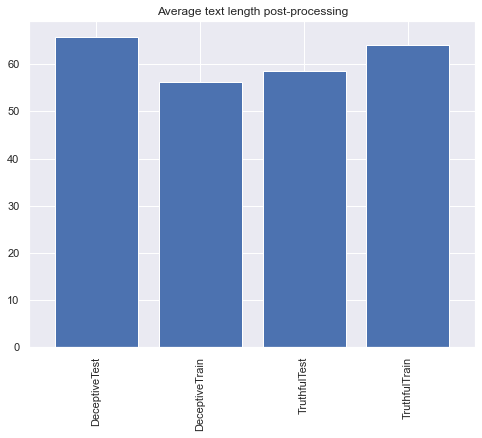

In [12]:
postAvgWordDeceptiveTest = avgWordCount(post_deceptive_test)
postAvgWordDeceptiveTrain = avgWordCount(post_deceptive_train)
postAvgWordTtruthfulTest = avgWordCount(post_truthful_test)
postAvgWordTruthfulTrain = avgWordCount(post_truthful_train)


metrics_df = pd.DataFrame([postAvgWordDeceptiveTest, postAvgWordDeceptiveTrain, postAvgWordTtruthfulTest, postAvgWordTruthfulTrain], columns=["Post-processing"], index=["DeceptiveTest", "DeceptiveTrain", "TruthfulTest", "TruthfulTrain"])
metrics_df.plot(kind='bar', legend=False, width=0.8, figsize=(8,6))
plt.title("Average text length post-processing")
plt.show()

In [18]:
# bag of words dataset creation
# create array with test and train data
datasets = [post_deceptive_test + post_truthful_test, post_deceptive_train + post_truthful_train]
datasets_stem = [post_deceptive_test_stem + post_truthful_test_stem, post_deceptive_train_stem + post_truthful_train_stem]
datasets_lemmatized = [post_deceptive_test_lemmatized + post_truthful_test_lemmatized, post_deceptive_train_lemmatized + post_truthful_train_lemmatized]

bag_of_words_data, bag_of_words_data_freq, vectorizer = bagOfWords(datasets = datasets, ngram = (1,1))
bag_of_words_data_stem, bag_of_words_data_freq_stem, a = bagOfWords(datasets = datasets_stem, ngram = (1,1))
bag_of_words_data_lemmatized, bag_of_words_data_freq_lemmatized, a = bagOfWords(datasets = datasets_lemmatized, ngram = (1,1))

    
bag_of_words_test = bag_of_words_data[0]
bag_of_words_train = bag_of_words_data[1]
bag_of_words_test_stem = bag_of_words_data_stem[0]
bag_of_words_train_stem = bag_of_words_data_stem[1]
bag_of_words_test_lemmatized = bag_of_words_data_lemmatized[0]
bag_of_words_train_lemmatized = bag_of_words_data_lemmatized[1]

y_test = np.array(bag_of_words_test[['class_target']].values.ravel())
X_test = bag_of_words_test.drop('class_target', axis=1)
y_train = np.array(bag_of_words_train[['class_target']].values.ravel())
X_train = bag_of_words_train.drop('class_target', axis=1)

y_test_stem = np.array(bag_of_words_test_stem[['class_target']].values.ravel())
X_test_stem = bag_of_words_test_stem.drop('class_target', axis=1)
y_train_stem = np.array(bag_of_words_train_stem[['class_target']].values.ravel())
X_train_stem = bag_of_words_train_stem.drop('class_target', axis=1)

y_test_lemmatized = np.array(bag_of_words_test_lemmatized[['class_target']].values.ravel())
X_test_lemmatized = bag_of_words_test_lemmatized.drop('class_target', axis=1)
y_train_lemmatized = np.array(bag_of_words_train_lemmatized[['class_target']].values.ravel())
X_train_lemmatized = bag_of_words_train_lemmatized.drop('class_target', axis=1)

y_test_list = [y_test, y_test_stem, y_test_lemmatized]
X_test_list = [X_test, X_test_stem, X_test_lemmatized]
y_train_list = [y_train, y_train_stem, y_train_lemmatized]
X_train_list = [X_train, X_train_stem, X_train_lemmatized]

#print(bag_of_words_test.head())

In [19]:
# bag of words bigram dataset creation
bigram_bag_of_words_data, bigram_bag_of_words_data_freq, vectorizer_bigram = bagOfWords(datasets = datasets, ngram = (2,2))

    
bigram_bag_of_words_test = bigram_bag_of_words_data[0]
bigram_bag_of_words_train = bigram_bag_of_words_data[1]

bigram_y_test = np.array(bigram_bag_of_words_test[['class_target']].values.ravel())
bigram_X_test = bigram_bag_of_words_test.drop('class_target', axis=1)
bigram_y_train = np.array(bigram_bag_of_words_train[['class_target']].values.ravel())
bigram_X_train = bigram_bag_of_words_train.drop('class_target', axis=1)

#print(bigram_bag_of_words_test.head())

{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   13.3s finished


Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}


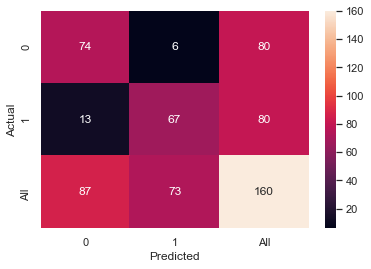

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    7.4s finished


Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}


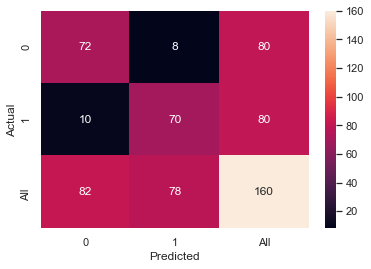

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
{'alpha': array([ 0.        ,  0.34482759,  0.68965517,  1.03448276,  1.37931034,
        1.72413793,  2.06896552,  2.4137931 ,  2.75862069,  3.10344828,
        3.44827586,  3.79310345,  4.13793103,  4.48275862,  4.82758621,
        5.17241379,  5.51724138,  5.86206897,  6.20689655,  6.55172414,
        6.89655172,  7.24137931,  7.5862069 ,  7.93103448,  8.27586207,
        8.62068966,  8.96551724,  9.31034483,  9.65517241, 10.        ]),
 'fit_prior': [True, False]}
Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 276 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:    8.6s finished


Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}


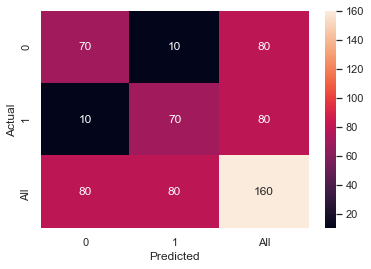

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000


In [21]:
# Naive bayes with hyper parameter tuning
from sklearn.naive_bayes import MultinomialNB
from pprint import pprint
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

mnb_metrics_list = list()
for y_test, X_test, y_train, X_train in zip(y_test_list, X_test_list, y_train_list, X_train_list):
    alpha = np.linspace(start = 0.0, stop = 10.0, num = 30)
    fit_prior = [True, False]

    # Create the random grid
    random_grid = {'alpha': alpha,
                   'fit_prior': fit_prior}
    pprint(random_grid)

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    mnb = MultinomialNB()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 60 different combinations, and use all available cores
    mnb_random = RandomizedSearchCV(estimator = mnb, param_distributions = random_grid, n_iter = 60, cv = 10, verbose=2, random_state=42, n_jobs = -1, scoring='f1')

    # Fit the random search model
    mnb_random.fit(X_train, y_train)

    # print the best parameters
    print("Best parameters")
    print(mnb_random.best_params_)

    # The best model
    mnb_best_random = mnb_random.best_estimator_

    # Predict Class
    mnb_random_y_pred = mnb_best_random.predict(X_test)

    # Accuracy 
    mnb_cm, mnb_metrics = getModelInfo(y_test, mnb_random_y_pred)
    mnb_metrics_list.append(mnb_metrics)


Standard configuration 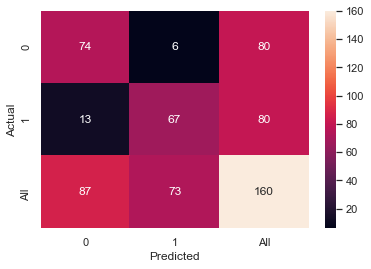
Best parameters
{'fit_prior': True, 'alpha': 1.7241379310344829}

Metrics: 
   Accuracy: 0.881250 
   Precision: 0.917808 
   Recall: 0.837500 
   F1: 0.875817
   

Stemming cv=10 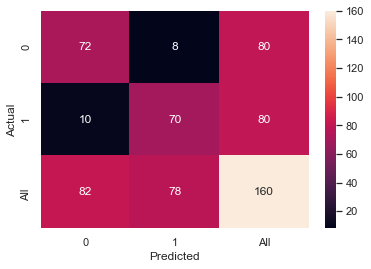
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.887500 
   Precision: 0.897436 
   Recall: 0.875000 
   F1: 0.886076
   
Lemmatization cv=10 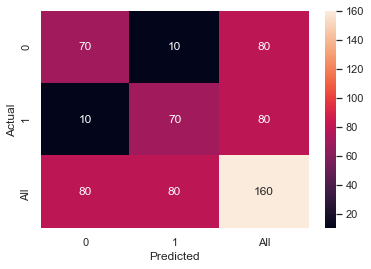
Best parameters
{'fit_prior': True, 'alpha': 0.3448275862068966}

Metrics: 
   Accuracy: 0.875000 
   Precision: 0.875000 
   Recall: 0.875000 
   F1: 0.875000

Processing  Word correction  Correction + stemming  Correction + lemmatization
Accuracy           0.881250               0.887500                       0.875
Precision          0.917808               0.897436                       0.875
Recall             0.837500               0.875000                       0.875
F-1                0.875817               0.886076                       0.875


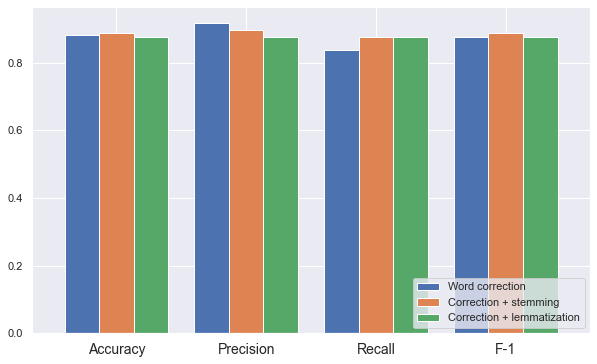

                            Accuracy  Precision  Recall       F-1
Processing                                                       
Word correction              0.88125   0.917808  0.8375  0.875817
Correction + stemming        0.88750   0.897436  0.8750  0.886076
Correction + lemmatization   0.87500   0.875000  0.8750  0.875000


In [25]:
mnb_metrics_list

def plotMetricsComparison(metrics_list, title=""):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"], index=["Word correction", "Correction + stemming", "Correction + lemmatization"])
    metrics_df.index.name = "Processing"
    print(metrics_df.transpose())
    ax = metrics_df.transpose().plot(kind='bar', legend=True, width=0.8, figsize=(10,6))
#     flat_list = [item for sublist in metrics_list for item in sublist]
#     for i, v in enumerate(flat_list):
#         ax.text(i-.25, 
#                   v/flat_list[i]+100, 
#                   flat_list[i], 
#                   fontsize=18)
    plt.legend(loc='lower right')
    plt.xticks(fontsize=14, rotation=0)
    plt.savefig("plots/preprocessing/" + title + '.png')
    plt.show()
    
    
    print(metrics_df)
    
def save_metrics(metrics_list, title="metrics"):
    metrics_df = pd.DataFrame(metrics_list, columns=["Accuracy","Precision","Recall", "F-1"])
    metrics_df = metrics_df.applymap(lambda x: round(x, 4))
    metrics_df.insert(loc=0, column='Preprocessing', value=["Word correction", "Correction + stemming", "Correction + lemmatization"]*4)
    metrics_df.insert(loc=0, column='Algorithm', value=[item for item in ["Multinomial naive Bayes","Logistic regression","Decision tree", "Random forest"] for i in range(3)])

    # round to 4 decimal places and save to csv file
    metrics_df.to_csv("tables/" + title + ".csv", sep = "&", index=False)
    
#save_metrics(mnb_metrics_list)
plotMetricsComparison(mnb_metrics_list, "pre_mnb")

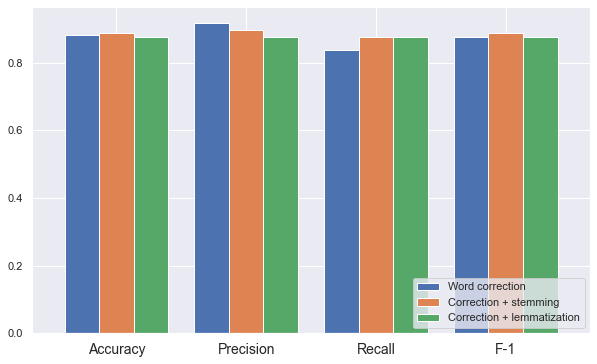

In [27]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(mnb_best_random.coef_))], axis = 1)
coefficients.columns = ['feature', 'coef']
# https://stackoverflow.com/questions/30486263/sorting-by-absolute-value-without-changing-the-data
#print(coefficients.reindex(coefficients.iloc[:,1].abs().sort_values(ascending=False).index)[0:])
#print(coefficients.groupby('coef').count())
# high_neg_mnb = coefficients.reindex(coefficients.iloc[:,1].abs().sort_values(ascending=False).index)['feature'][:801]

# unique, counts = np.unique(mnb_best_random.coef_, return_counts=True)
# dict(zip(unique, counts))

neg_class_prob_sorted = mnb_best_random.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = mnb_best_random.feature_log_prob_[1, :].argsort()
print(neg_class_prob_sorted)
print(pos_class_prob_sorted)
print(list(np.take(X_train.columns, neg_class_prob_sorted[-10:])))
print(list(np.take(X_train.columns, pos_class_prob_sorted[-10:])))

[   0  983  987 ...  300 1521  866]
[   0  928  931 ...  794 1521  866]
['not', 'stayed', 'would', 'service', 'staff', 'great', 'stay', 'chicago', 'room', 'hotel']
['night', 'stayed', 'would', 'location', 'staff', 'chicago', 'stay', 'great', 'room', 'hotel']


In [374]:
import tensorflow as tf
batch_size = 32
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=1337,
)
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=1337,
)

raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    "data/keras_test",
    batch_size=batch_size
)

print(
    "Number of batches in raw_train_ds: %d"
    % tf.data.experimental.cardinality(raw_train_ds)
)
print(
    "Number of batches in raw_val_ds: %d" % tf.data.experimental.cardinality(raw_val_ds)
)
print(
    "Number of batches in raw_test_ds: %d"
    % tf.data.experimental.cardinality(raw_test_ds)
)
# inspect a few samples
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print(text_batch.numpy()[i])
        print(label_batch.numpy()[i])

Found 640 files belonging to 2 classes.
Using 512 files for training.
Found 640 files belonging to 2 classes.
Using 128 files for validation.
Found 160 files belonging to 2 classes.
Number of batches in raw_train_ds: 16
Number of batches in raw_val_ds: 4
Number of batches in raw_test_ds: 5
b"My husband and I recently stayed at your Hard Rock Hotel in Chicago, and what a fantastic experience it was. We stayed in one of the 'Extreme Suites' and let me tell you it was beautiful. The furniture and paintings were amazing and the view was to die for. The staff treated us really well and met all of our needs and then some. I especially loved the spa. We stayed for a week but I could have stayed a lot longer. It was very comfortable and welcoming. We will make sure to recommend your hotel to our friends and will be back the next time we are in Chicago. Thanks so much!\n"
0
b'We stayed at the beautiful Millennium Knickerbocker Hotel located in scenic downtown Chicago. It was close to shopping, 

In [378]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
# Model constants.
max_features = 20000
embedding_dim = 100
#embedding_dim = 100
sequence_length = 300

# Now that we have our custom standardization, we can instantiate our text
# vectorization layer. We are using this layer to normalize, split, and map
# strings to integers, so we set our 'output_mode' to 'int'.
# Note that we're using the default split function,
# and the custom standardization defined above.
# We also set an explicit maximum sequence length, since the CNNs later in our
# model won't support ragged sequences.
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)
# Let's make a text-only dataset (no labels):
text_ds = raw_train_ds.map(lambda x, y: x)
# Let's call `adapt`:
vectorize_layer.adapt(text_ds)


def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label


# Vectorize the data.
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)


x_train = np.concatenate([x for x, y in train_ds])  
y_train = np.concatenate([y for x, y in train_ds])  
x_val = np.concatenate([x for x, y in val_ds])  
y_val = np.concatenate([y for x, y in val_ds])  
x_test = np.concatenate([x for x, y in test_ds], axis=0)  
y_test = np.concatenate([y for x, y in test_ds], axis=0)  

In [376]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()



In [379]:
from tensorflow.keras import layers

# # A integer input for vocab indices.
# inputs = tf.keras.Input(shape=(None,), dtype="int64", name="input")

# # Next, we add a layer to map those vocab indices into a space of dimensionality
# # 'embedding_dim'.
# x = layers.Embedding(max_features, embedding_dim)(inputs)
# x = layers.Dropout(0.5)(x)

# # Conv1D + global max pooling
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
# x = layers.GlobalMaxPooling1D()(x)

# # We add a vanilla hidden layer:
# x = layers.Dense(128, activation="relu")(x)
# x = layers.Dropout(0.5)(x)

# # We project onto a single unit output layer, and squash it with a sigmoid:
# predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model = keras.Sequential()
model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
model.add(layers.Embedding(max_features, embedding_dim))
# model.add(Embedding(
#     num_tokens,
#     embedding_dim,
#     embeddings_initializer=keras.initializers.Constant(embedding_matrix),
#     trainable=False,
# ))

model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation = "sigmoid", name="predictions"))
# Compile the model with binary crossentropy loss and an adam optimizer.
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [380]:
epochs = 150

# Fit the model using the train and test datasets.
history = model.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs)
# history = model.fit(x_train, y_train, 
#                     validation_data=(x_val, y_val), 
#                     epochs=epochs)

Epoch 1/150
16/16 [==============================] - 1s 49ms/step - loss: 0.6918 - accuracy: 0.5020 - val_loss: 0.6955 - val_accuracy: 0.4375
Epoch 2/150
16/16 [==============================] - 1s 45ms/step - loss: 0.6866 - accuracy: 0.5566 - val_loss: 0.6984 - val_accuracy: 0.4375
Epoch 3/150
16/16 [==============================] - 1s 47ms/step - loss: 0.6808 - accuracy: 0.6016 - val_loss: 0.6884 - val_accuracy: 0.5234
Epoch 4/150
16/16 [==============================] - 1s 44ms/step - loss: 0.6729 - accuracy: 0.6387 - val_loss: 0.6848 - val_accuracy: 0.4688
Epoch 5/150
16/16 [==============================] - 1s 45ms/step - loss: 0.6403 - accuracy: 0.7246 - val_loss: 0.6542 - val_accuracy: 0.7266
Epoch 6/150
16/16 [==============================] - 1s 47ms/step - loss: 0.5673 - accuracy: 0.8633 - val_loss: 0.6298 - val_accuracy: 0.6641
Epoch 7/150
16/16 [==============================] - 1s 45ms/step - loss: 0.4474 - accuracy: 0.8770 - val_loss: 0.5390 - val_accuracy: 0.7266
Epoch 

16/16 [==============================] - 1s 61ms/step - loss: 9.7017e-05 - accuracy: 1.0000 - val_loss: 0.4213 - val_accuracy: 0.8594
Epoch 58/150
16/16 [==============================] - 1s 62ms/step - loss: 1.1589e-04 - accuracy: 1.0000 - val_loss: 0.4281 - val_accuracy: 0.8594
Epoch 59/150
16/16 [==============================] - 1s 60ms/step - loss: 1.3238e-04 - accuracy: 1.0000 - val_loss: 0.4280 - val_accuracy: 0.8594
Epoch 60/150
16/16 [==============================] - 1s 60ms/step - loss: 1.0265e-04 - accuracy: 1.0000 - val_loss: 0.4289 - val_accuracy: 0.8594
Epoch 61/150
16/16 [==============================] - 1s 57ms/step - loss: 1.0416e-04 - accuracy: 1.0000 - val_loss: 0.4294 - val_accuracy: 0.8594
Epoch 62/150
16/16 [==============================] - 1s 58ms/step - loss: 7.8486e-05 - accuracy: 1.0000 - val_loss: 0.4282 - val_accuracy: 0.8750
Epoch 63/150
16/16 [==============================] - 1s 57ms/step - loss: 1.1916e-04 - accuracy: 1.0000 - val_loss: 0.4259 - val_a

Epoch 113/150
16/16 [==============================] - 1s 55ms/step - loss: 5.0832e-05 - accuracy: 1.0000 - val_loss: 0.4844 - val_accuracy: 0.8750
Epoch 114/150
16/16 [==============================] - 1s 65ms/step - loss: 2.3400e-05 - accuracy: 1.0000 - val_loss: 0.4848 - val_accuracy: 0.8750
Epoch 115/150
16/16 [==============================] - 1s 68ms/step - loss: 5.5472e-05 - accuracy: 1.0000 - val_loss: 0.4914 - val_accuracy: 0.8750
Epoch 116/150
16/16 [==============================] - 1s 75ms/step - loss: 1.6067e-05 - accuracy: 1.0000 - val_loss: 0.4992 - val_accuracy: 0.8750
Epoch 117/150
16/16 [==============================] - 1s 79ms/step - loss: 2.3545e-05 - accuracy: 1.0000 - val_loss: 0.4997 - val_accuracy: 0.8750
Epoch 118/150
16/16 [==============================] - 1s 82ms/step - loss: 1.3883e-05 - accuracy: 1.0000 - val_loss: 0.5034 - val_accuracy: 0.8828
Epoch 119/150
16/16 [==============================] - 1s 72ms/step - loss: 1.8207e-05 - accuracy: 1.0000 - val_

5/5 [==============================] - 0s 5ms/step - loss: 0.6249 - accuracy: 0.8625
Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_104 (Embedding)    (None, None, 100)         2000000   
_________________________________________________________________
dropout_89 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_107 (Conv1D)          (None, None, 128)         89728     
_________________________________________________________________
global_max_pooling1d_101 (Gl (None, 128)               0         
_________________________________________________________________
flatten_53 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_161 (Dense)            (None, 128)               16512     
__________________________________

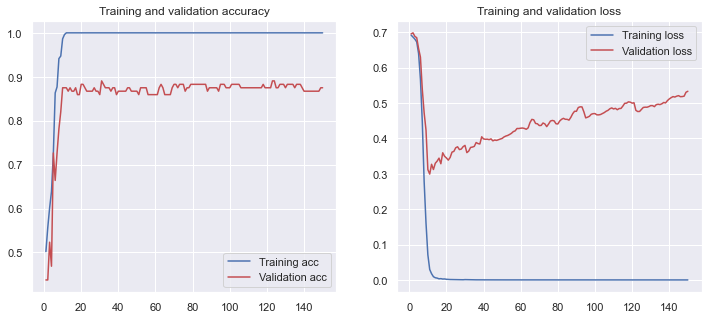

In [381]:
model.evaluate(test_ds)
plot_history(history)
model.summary()

5/5 [==============================] - 0s 9ms/step - loss: 0.3945 - accuracy: 0.8875
Model: "sequential_84"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
embedding_83 (Embedding)     (None, None, 256)         5120000   
_________________________________________________________________
dropout_59 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
conv1d_82 (Conv1D)           (None, None, 128)         229504    
_________________________________________________________________
global_max_pooling1d_82 (Glo (None, 128)               0         
_________________________________________________________________
flatten_39 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_145 (Dense)            (None, 128)               16512     
_________________________________________________________________
dropout_60 (Dropout)         (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 129       
=================================================================
Total params: 5,366,145
Trainable params: 5,366,145
Non-trainable params: 0
_________________________________________________________________
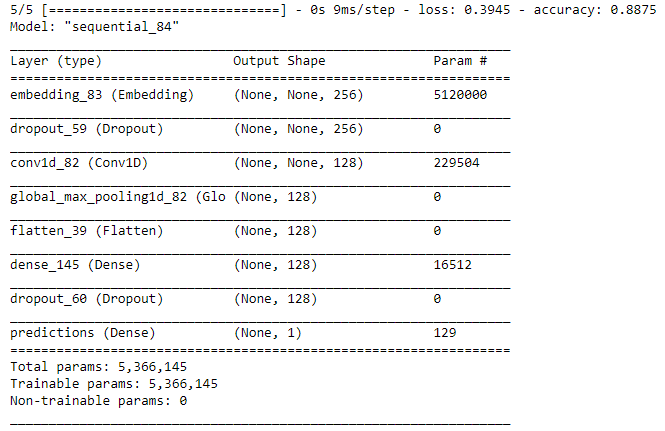
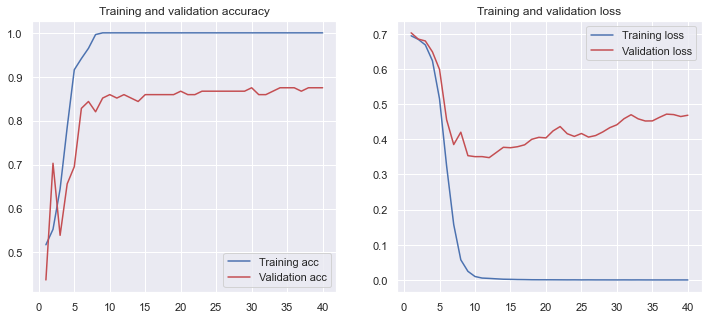

In [347]:
os.chdir(r"C:\Users\quach\OneDrive\Desktop\Code\Python")
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [348]:
import sys
import pathlib

data_path = r"C:\Users\quach\OneDrive\Desktop\Code\Python\data\embedded"
data_dir = pathlib.Path(data_path)
print(data_dir)
samples = []
labels = []
class_names = []
class_index = 0
for dirname in sorted(os.listdir(data_dir)):
    class_names.append(dirname)
    dirpath = data_dir / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples.append(content)
        labels.append(class_index)
    class_index += 1

print("Classes:", class_names)
print("Number of samples:", len(samples))


data_path_test = r"C:\Users\quach\OneDrive\Desktop\Code\Python\data\embedded_test"
data_dir_test = pathlib.Path(data_path_test)
samples_test = []
labels_test = []
class_names_test = []
class_index = 0

for dirname in sorted(os.listdir(data_dir_test)):
    class_names_test.append(dirname)
    dirpath = data_dir_test / dirname
    fnames = os.listdir(dirpath)
    print("Processing %s, %d files found" % (dirname, len(fnames)))
    for fname in fnames:
        fpath = dirpath / fname
        f = open(fpath, encoding="latin-1")
        content = f.read()
        samples_test.append(content)
        labels_test.append(class_index)
    class_index += 1

print("Classes test:", class_names_test)
print("Number of samples test:", len(samples_test))


# Shuffle the data
seed = 1337
rng = np.random.RandomState(seed)
rng.shuffle(samples)
rng = np.random.RandomState(seed)
rng.shuffle(labels)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(samples))
train_samples = samples[:-num_validation_samples]
val_samples = samples[-num_validation_samples:]
train_labels = labels[:-num_validation_samples]
val_labels = labels[-num_validation_samples:]

C:\Users\quach\OneDrive\Desktop\Code\Python\data\embedded
Processing deceptive, 320 files found
Processing truthful, 320 files found
Classes: ['deceptive', 'truthful']
Number of samples: 640
Processing deceptive, 80 files found
Processing truthful, 80 files found
Classes test: ['deceptive', 'truthful']
Number of samples test: 160


In [349]:
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)
vectorizer.get_vocabulary()[:5]
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [350]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4189 words (458 misses)


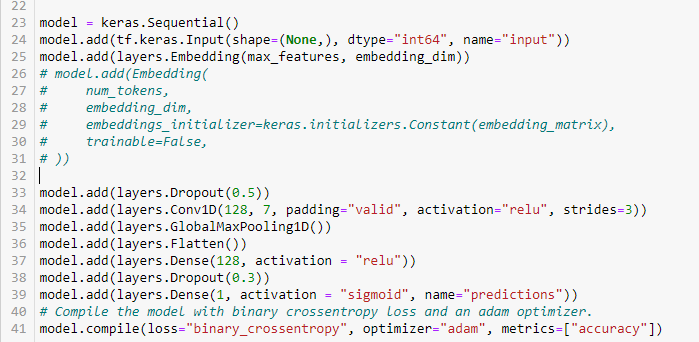

In [383]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)





int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Dropout(0.5)(embedded_sequences)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.3)(x)
predictions = layers.Dense(1, activation="sigmoid", name="predictions")(x)
model = keras.Model(int_sequences_input, predictions)

In [395]:
from tensorflow.keras.optimizers import Adam
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()
x_test = vectorizer(np.array([[s] for s in test_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)
y_test = np.array(labels_test)

model.compile(
    loss="binary_crossentropy", optimizer=Adam(lr=0.01), metrics=["accuracy"]
)
history = model.fit(x_train, y_train, batch_size=128, epochs=500, validation_data=(x_val, y_val))

Epoch 1/500
4/4 [==============================] - 0s 52ms/step - loss: 0.1164 - accuracy: 0.9434 - val_loss: 0.9007 - val_accuracy: 0.7188
Epoch 2/500
4/4 [==============================] - 0s 34ms/step - loss: 0.1185 - accuracy: 0.9375 - val_loss: 0.9186 - val_accuracy: 0.7422
Epoch 3/500
4/4 [==============================] - 0s 34ms/step - loss: 0.0872 - accuracy: 0.9551 - val_loss: 1.0824 - val_accuracy: 0.7500
Epoch 4/500
4/4 [==============================] - 0s 35ms/step - loss: 0.1076 - accuracy: 0.9551 - val_loss: 1.1932 - val_accuracy: 0.7422
Epoch 5/500
4/4 [==============================] - 0s 34ms/step - loss: 0.1403 - accuracy: 0.9414 - val_loss: 1.2383 - val_accuracy: 0.7188
Epoch 6/500
4/4 [==============================] - 0s 34ms/step - loss: 0.1117 - accuracy: 0.9316 - val_loss: 1.0647 - val_accuracy: 0.7344
Epoch 7/500
4/4 [==============================] - 0s 33ms/step - loss: 0.0767 - accuracy: 0.9668 - val_loss: 0.9711 - val_accuracy: 0.7500
Epoch 8/500
4/4 [===

4/4 [==============================] - 0s 34ms/step - loss: 0.0886 - accuracy: 0.9707 - val_loss: 1.1604 - val_accuracy: 0.7188
Epoch 60/500
4/4 [==============================] - 0s 36ms/step - loss: 0.1022 - accuracy: 0.9590 - val_loss: 0.9390 - val_accuracy: 0.7500
Epoch 61/500
4/4 [==============================] - 0s 35ms/step - loss: 0.0564 - accuracy: 0.9785 - val_loss: 0.8692 - val_accuracy: 0.7656
Epoch 62/500
4/4 [==============================] - 0s 36ms/step - loss: 0.0756 - accuracy: 0.9629 - val_loss: 0.9409 - val_accuracy: 0.7656
Epoch 63/500
4/4 [==============================] - 0s 35ms/step - loss: 0.0529 - accuracy: 0.9824 - val_loss: 1.0442 - val_accuracy: 0.7734
Epoch 64/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0658 - accuracy: 0.9707 - val_loss: 1.0949 - val_accuracy: 0.7734
Epoch 65/500
4/4 [==============================] - 0s 58ms/step - loss: 0.0814 - accuracy: 0.9746 - val_loss: 0.9616 - val_accuracy: 0.7656
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 48ms/step - loss: 0.0470 - accuracy: 0.9785 - val_loss: 1.3448 - val_accuracy: 0.7812
Epoch 118/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0434 - accuracy: 0.9805 - val_loss: 1.5556 - val_accuracy: 0.7812
Epoch 119/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0494 - accuracy: 0.9746 - val_loss: 1.5185 - val_accuracy: 0.7812
Epoch 120/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0336 - accuracy: 0.9844 - val_loss: 1.5655 - val_accuracy: 0.7812
Epoch 121/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0638 - accuracy: 0.9688 - val_loss: 1.4750 - val_accuracy: 0.7812
Epoch 122/500
4/4 [==============================] - 0s 46ms/step - loss: 0.0728 - accuracy: 0.9707 - val_loss: 1.5082 - val_accuracy: 0.7812
Epoch 123/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0537 - accuracy: 0.9785 - val_loss: 1.5560 - val_accuracy: 0.7812
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0208 - accuracy: 0.9922 - val_loss: 1.4295 - val_accuracy: 0.7422
Epoch 176/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0270 - accuracy: 0.9902 - val_loss: 1.4947 - val_accuracy: 0.7422
Epoch 177/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0302 - accuracy: 0.9902 - val_loss: 1.6666 - val_accuracy: 0.7422
Epoch 178/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0370 - accuracy: 0.9883 - val_loss: 1.8092 - val_accuracy: 0.7500
Epoch 179/500
4/4 [==============================] - 0s 49ms/step - loss: 0.1247 - accuracy: 0.9766 - val_loss: 2.0167 - val_accuracy: 0.7422
Epoch 180/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0541 - accuracy: 0.9883 - val_loss: 1.5620 - val_accuracy: 0.7578
Epoch 181/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0455 - accuracy: 0.9844 - val_loss: 1.1661 - val_accuracy: 0.7812
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0259 - accuracy: 0.9941 - val_loss: 1.0476 - val_accuracy: 0.7734
Epoch 234/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0331 - accuracy: 0.9863 - val_loss: 1.1900 - val_accuracy: 0.7578
Epoch 235/500
4/4 [==============================] - 0s 48ms/step - loss: 0.0305 - accuracy: 0.9902 - val_loss: 1.4974 - val_accuracy: 0.7188
Epoch 236/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0491 - accuracy: 0.9785 - val_loss: 1.7105 - val_accuracy: 0.7266
Epoch 237/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0497 - accuracy: 0.9785 - val_loss: 1.6023 - val_accuracy: 0.7578
Epoch 238/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0374 - accuracy: 0.9922 - val_loss: 1.4589 - val_accuracy: 0.7578
Epoch 239/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0284 - accuracy: 0.9863 - val_loss: 1.3454 - val_accuracy: 0.7656
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 62ms/step - loss: 0.0389 - accuracy: 0.9902 - val_loss: 1.3501 - val_accuracy: 0.7266
Epoch 292/500
4/4 [==============================] - 0s 57ms/step - loss: 0.0252 - accuracy: 0.9922 - val_loss: 1.3194 - val_accuracy: 0.7188
Epoch 293/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0297 - accuracy: 0.9844 - val_loss: 1.3396 - val_accuracy: 0.7344
Epoch 294/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0332 - accuracy: 0.9863 - val_loss: 1.4902 - val_accuracy: 0.7422
Epoch 295/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0161 - accuracy: 0.9941 - val_loss: 1.6987 - val_accuracy: 0.7422
Epoch 296/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0352 - accuracy: 0.9902 - val_loss: 1.8865 - val_accuracy: 0.7344
Epoch 297/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0218 - accuracy: 0.9922 - val_loss: 2.0900 - val_accuracy: 0.7344
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0518 - accuracy: 0.9902 - val_loss: 1.3847 - val_accuracy: 0.7344
Epoch 350/500
4/4 [==============================] - 0s 48ms/step - loss: 0.0159 - accuracy: 0.9941 - val_loss: 1.1453 - val_accuracy: 0.7500
Epoch 351/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0387 - accuracy: 0.9844 - val_loss: 1.1788 - val_accuracy: 0.7266
Epoch 352/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0214 - accuracy: 0.9922 - val_loss: 1.2285 - val_accuracy: 0.7266
Epoch 353/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0329 - accuracy: 0.9863 - val_loss: 1.2945 - val_accuracy: 0.7344
Epoch 354/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0232 - accuracy: 0.9941 - val_loss: 1.3742 - val_accuracy: 0.7344
Epoch 355/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0391 - accuracy: 0.9883 - val_loss: 1.5337 - val_accuracy: 0.7344
Epoch 

Epoch 407/500
4/4 [==============================] - 0s 48ms/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 1.5477 - val_accuracy: 0.7344
Epoch 408/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0080 - accuracy: 0.9980 - val_loss: 1.5213 - val_accuracy: 0.7422
Epoch 409/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0140 - accuracy: 0.9961 - val_loss: 1.5480 - val_accuracy: 0.7500
Epoch 410/500
4/4 [==============================] - 0s 48ms/step - loss: 0.0307 - accuracy: 0.9961 - val_loss: 1.6981 - val_accuracy: 0.7344
Epoch 411/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0164 - accuracy: 0.9922 - val_loss: 2.0317 - val_accuracy: 0.7422
Epoch 412/500
4/4 [==============================] - 0s 47ms/step - loss: 0.0261 - accuracy: 0.9922 - val_loss: 1.8956 - val_accuracy: 0.7344
Epoch 413/500
4/4 [==============================] - 0s 49ms/step - loss: 0.0517 - accuracy: 0.9902 - val_loss: 1.4077 - val_accuracy: 0.7734
Epoch 

Epoch 465/500
4/4 [==============================] - 0s 53ms/step - loss: 0.0304 - accuracy: 0.9902 - val_loss: 1.8603 - val_accuracy: 0.7422
Epoch 466/500
4/4 [==============================] - 0s 54ms/step - loss: 0.0191 - accuracy: 0.9922 - val_loss: 1.8554 - val_accuracy: 0.7422
Epoch 467/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0280 - accuracy: 0.9902 - val_loss: 1.7799 - val_accuracy: 0.7344
Epoch 468/500
4/4 [==============================] - 0s 50ms/step - loss: 0.0216 - accuracy: 0.9902 - val_loss: 1.8110 - val_accuracy: 0.7344
Epoch 469/500
4/4 [==============================] - 0s 51ms/step - loss: 0.0880 - accuracy: 0.9883 - val_loss: 1.7020 - val_accuracy: 0.7266
Epoch 470/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0383 - accuracy: 0.9863 - val_loss: 1.6880 - val_accuracy: 0.7031
Epoch 471/500
4/4 [==============================] - 0s 52ms/step - loss: 0.0291 - accuracy: 0.9902 - val_loss: 1.5445 - val_accuracy: 0.7031
Epoch 

5/5 [==============================] - 0s 6ms/step - loss: 1.5905 - accuracy: 0.7875
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_105 (Embedding)    (None, None, 100)         464900    
_________________________________________________________________
dropout_91 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
conv1d_108 (Conv1D)          (None, None, 128)         89728     
_________________________________________________________________
global_max_pooling1d_102 (Gl (None, 128)               0         
_________________________________________________________________
flatten_54 (Flatten)         (None, 128)               0         
__________________________________

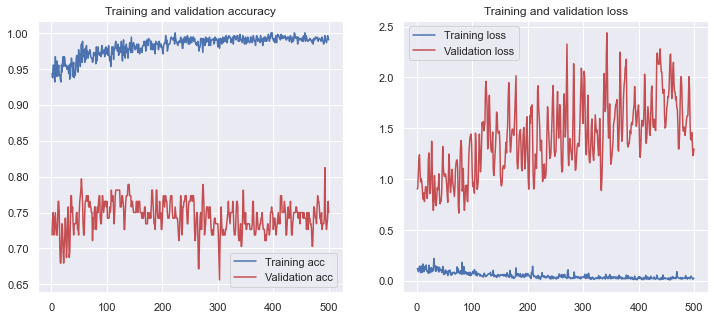

In [396]:
model.evaluate(test_ds)
plot_history(history)
model.summary()

In [297]:
print(history)

In [174]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(max_features, embedding_dim))
    model.add(layers.Conv1D(num_filters, kernel_size, padding="valid", activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = "relu"))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def create_model(x_train, y_train, val_ds x_test, y_test):
    num_classes = y_train.shape[1]
    num_tokens = x_train.shape[1]

    model = keras.Sequential()
    model.add(tf.keras.Input(shape=(None,), dtype="int64", name="input"))
    model.add(layers.Embedding(max_features, embedding_dim))
    model.add(Embedding(vocab_size, output_dim = {{choice([60, 80, 100])}}, input_length = max_length))
    model.add(Dropout({{choice([0.3, 0.4, 0.5, 0.6])}}))
    model.add(Conv1D(filters = {{choice([50, 60, 80])}}, kernel_size = {{choice([10,15,20,30])}}, padding='valid', activation='relu', strides=1))
    model.add(GlobalMaxPool1D())
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer={{choice(['adam', 'sgd'])}},
                  metrics=['accuracy'])

  # Optional to log output from Keras
    csv_logger = keras.callbacks.CSVLogger('Logs/dl_model.log')
    
    result = model.fit(x_train, y_train,
              batch_size=128,
              epochs=10,
              verbose=0,
              validation_data=val_ds,
              callbacks=[csv_logger])
    #get the highest validation accuracy of the training epochs
    validation_acc = np.amax(result.history['val_acc']) 
    print('Best validation acc of epoch:', validation_acc)
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}
# Main settings
epochs = 20
embedding_dim = 128
maxlen = 500
output_file = 'data/output.txt'
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[5000], 
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen])

model = KerasClassifier(build_fn=create_model,
                            epochs=epochs, batch_size=10,
                            verbose=False)
grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)
grid_result = grid.fit(x_train, y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test, y_test)



Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *ar

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 223, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\wrappers\scikit_learn.py", line 166, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\pytho

ValueError: in user code:

    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:985 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:372 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:386 call
        inputs, training=training, mask=mask)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\functional.py:508 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:180 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer global_max_pooling1d_70 is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: [None, 32, 498, 128]


In [97]:

help(keras.losses)

Help on package tensorflow.keras.losses in tensorflow.keras:

NAME
    tensorflow.keras.losses - Built-in loss functions.

PACKAGE CONTENTS


FILE
    c:\programdata\anaconda3\lib\site-packages\tensorflow\keras\losses\__init__.py


